# RUL Prediction Video

In [1]:
import numpy as np
import torch
from pickle import load,dump
from datetime import date
import os

# Custom modules
from method import compute_eval_matrices
from visualization import make_rul_video 
from watercan import GroupWaterCan
from helpers import get_from, np2gpu

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Fix Seed

In [3]:
seed=0
# Set seed for NumPy
np.random.seed(seed)

import torch

# Set seed for PyTorch (both CPU and CUDA if available)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Get the data

In [4]:
dataset_name='N-CMAPSS_DS01' #'uav_data'#
threshold_name=''#'-0.1' #  '+0.1' #

#Eval parameters
std_bound=0
poly_deg=0

# Load test data

In [5]:
with open(f'./data/{dataset_name}/performs_info.pkl', 'rb') as file:
    performs_info=load(file)

with open(f'./data/{dataset_name}/time_info.pkl', 'rb') as file:
    time_info=load(file)
    
with open(f'./data/{dataset_name}/times_test{threshold_name}.pkl', 'rb') as file:
    t_observ = load(file)

with open(f'./data/{dataset_name}/times_test{threshold_name}_threshold.pkl', 'rb') as file:
    times_thresholds = load(file)

with open(f'./data/{dataset_name}/RUL_test{threshold_name}.pkl', 'rb') as file:
    rul= load(file)

with open(f'./data/{dataset_name}/EOLcause_test{threshold_name}.pkl', 'rb') as file:
    EOLcause= load(file)

performs = {}
thresholds = {}
for name in performs_info.keys():
    with open(f'./data/{dataset_name}/{name}_test{threshold_name}.pkl', 'rb') as file:
        performs[name] = load(file)
    with open(f'./data/{dataset_name}/{name}_test{threshold_name}_threshold.pkl', 'rb') as file:
        thresholds[name]= load(file)

EOLcause

['HPT_eff', 'HPT_eff', 'HPT_eff', 'HPT_eff']

## Add time 0

In [6]:
rul_intercept=[r[0]-(r[0]-r[1])/(time[0]-time[1])*time[0] for time,r in zip(t_observ,rul)]
rul=[np.concatenate([np.array((inter,)),ru])  for inter,ru in zip(rul_intercept,rul)]

## Choose Library

In [7]:
library_address=f'./Library/MTL_2024-09-20_{dataset_name}/'

## Load Group Distribution

In [8]:
group_distributions={}
for perform_name in performs_info.keys():
    perform_info=performs_info[perform_name]

    perform_address=library_address+f'{perform_name}/'

    configs=torch.load(perform_address+'config.pth')
    model_state=torch.load(perform_address+'model_state.pth')
    model=GroupWaterCan(configs)
    model.load_state_dict(model_state)
    model.to(device)
    if poly_deg or std_bound:
        with open(f'./data/{dataset_name}/times.pkl', 'rb') as file:
            train_time = load(file)
        xs_train=[np2gpu(time,device).unsqueeze(1) for time in train_time]
        if std_bound:
            max_std_ontrain=max([max(out[:,1]) for out in model(xs_train)]).item()
            model.std_bound=std_bound*max_std_ontrain
        if poly_deg:
            model.set_taylor_extension(xs_train,poly_deg)
            model.extend()
    group_distributions[perform_name]=model
t_observ_torch=[torch.tensor(time,device=device,dtype=torch.float32).unsqueeze(dim=1) for time in t_observ]

# Compute and prepare A,b matrices and time

In [9]:
n_test_unit=len(t_observ)
As,Ss=compute_eval_matrices(group_distributions,t_observ_torch)
test_unit_list=range(n_test_unit)
bs = performs

## Choose Experiment parameters

In [10]:
# Performance-independent parameters
n_train_unit =6 #20 # 
n_paths = 60 # 20 #
lr=1
forgetting=1
conserv_pred=0.5
gama_value=1

# Performance-dependent parameters
gamma={key:gama_value for key,perform in performs_info.items()} #perform['default_gamma'] #reaction_delay
max_life =time_info['max_life']


# Visualization
accel=15*3600
time_unit=time_info['time_unit']
#max_life=max([time[-1] for time in t_observ])
t = np.linspace(0, int(max_life+5), int((max_life+5)*20))

In [11]:
config={'n_train_unit':n_train_unit,
        'n_paths':n_paths,
        'lr':lr,
        'conserv_pred':conserv_pred,
        'gamma':gamma,
        'max_life':max_life}

## Set Experiment name

In [12]:
today = date.today()
threshold_text=0 if not threshold_name else threshold_name

In [13]:
exp=f'threshold{threshold_text}_{today}_try1_gamma{gama_value}_lr{lr}_forgetting{forgetting}_seed{seed}/'

#exp='try'

if exp == 'try':
    n_train_unit =5 #5#
    n_paths =5 #5# 

## Save experiment configuration

In [14]:
exp_address=library_address+f'_Experiments/{exp}'
os.makedirs(exp_address, exist_ok=True)
with open(exp_address+'config.pth', "wb") as f:
    dump(config, f)

## Predicts

time 0, present alpha var: [0.14124294 0.0960452  0.15254237 0.18644068 0.15254237 0.11864407]
time 0, future alpha var: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
time 1, present alpha var: [0.164826   0.05361117 0.08429974 0.4715964  0.11136471 0.08586773]
time 1, future alpha var: [0.19996748 0.19307906 0.23874081 0.20337995 0.22164421 0.2314686 ]
time 2, present alpha var: [0.0547946  0.24569239 0.24945015 0.29037917 0.09506071 0.10768893]
time 2, future alpha var: [0.22772692 0.36785481 0.1836424  0.3773585  0.23393704 0.22396544]
time 3, present alpha var: [0.133687   0.26149675 0.25759795 0.27542296 0.20840184 0.29230446]
time 3, future alpha var: [0.20338524 0.34108591 0.28929382 0.26459522 0.27609293 0.35462237]
time 4, present alpha var: [0.10732718 0.50143886 0.8654556  0.20483772 0.02776336 0.15276712]
time 4, future alpha var: [0.21950647 0.43997051 0.26179233 0.27292634 0.21893845 0.30429656]
time 5, present alpha var: [0.09876033 0.21332984 1.215

Moviepy - Done !
Moviepy - video ready ./Library/MTL_2024-09-20_N-CMAPSS_DS01/_Experiments/threshold0_2024-09-21_try1_gamma1_lr1_forgetting1_seed0/unit0_pred.mp4
RMSE_acc: 5.301876093411662
RMSE_csv: 13.050619959169806
RMSE_unc: 10.946924903148137
time 0, present alpha var: [0.1299435  0.11864407 0.16384181 0.11864407 0.15254237 0.16384181]
time 0, future alpha var: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
time 1, present alpha var: [0.0636645  0.04266135 0.52567244 0.10010388 0.13771762 0.14718184]
time 1, future alpha var: [0.18781444 0.17939195 0.19552552 0.22877188 0.21932533 0.2022602 ]
time 2, present alpha var: [0.12601638 3.9273434  0.25154322 0.0782975  0.24690914 0.30430073]
time 2, future alpha var: [0.1609922  0.22617892 0.20698037 0.15226836 0.17921988 0.19918499]
time 3, present alpha var: [0.40667015 3.0699303  0.78942776 0.06771783 0.17122714 0.08446142]
time 3, future alpha var: [0.31074442 4.62547676 0.28236783 0.28905799 0.46377049 0.556001

Moviepy - Done !
Moviepy - video ready ./Library/MTL_2024-09-20_N-CMAPSS_DS01/_Experiments/threshold0_2024-09-21_try1_gamma1_lr1_forgetting1_seed0/unit1_pred.mp4
RMSE_acc: 4.163331998932265
RMSE_csv: 12.340988615179905
RMSE_unc: 8.881941729649485
time 0, present alpha var: [0.14124294 0.14124294 0.19774011 0.1299435  0.11864407 0.11864407]
time 0, future alpha var: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
time 1, present alpha var: [0.06773254 0.07266957 0.06954963 0.05580929 0.01966975 0.13675827]
time 1, future alpha var: [0.20402585 0.2122871  0.21772054 0.19139233 0.16792393 0.29117902]
time 2, present alpha var: [0.04945769 0.29924864 1.1726376  0.1582501  0.04710506 0.1942282 ]
time 2, future alpha var: [0.19211543 0.33768442 0.21609212 0.24731153 0.18667152 0.25706946]
time 3, present alpha var: [0.33930293 0.21926863 0.2689203  0.04436847 0.33062664 0.17830205]
time 3, future alpha var: [0.25284198 0.23286516 0.48537466 0.18724493 0.4720512  0.3300474

Moviepy - Done !
Moviepy - video ready ./Library/MTL_2024-09-20_N-CMAPSS_DS01/_Experiments/threshold0_2024-09-21_try1_gamma1_lr1_forgetting1_seed0/unit2_pred.mp4
RMSE_acc: 9.690264937962286
RMSE_csv: 7.425348642934943
RMSE_unc: 19.545451935374242
time 0, present alpha var: [0.17514124 0.11864407 0.14124294 0.0960452  0.19774011 0.11864407]
time 0, future alpha var: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
time 1, present alpha var: [0.09656915 0.16608709 0.8640471  0.10881308 0.15550262 0.0652344 ]
time 1, future alpha var: [0.21861667 0.26380764 0.19680686 0.18330994 0.19110211 0.2013899 ]
time 2, present alpha var: [0.0271566  0.05261083 0.15131618 0.01883389 0.0569269  0.00799912]
time 2, future alpha var: [0.16519946 0.18454658 0.29975801 0.15480715 0.19657724 0.14624214]
time 3, present alpha var: [0.04574854 0.15144789 0.07686252 0.0368983  0.19372834 0.0331633 ]
time 3, future alpha var: [0.18295671 0.28395312 0.22367662 0.17112661 0.33385041 0.1730018

Moviepy - Done !
Moviepy - video ready ./Library/MTL_2024-09-20_N-CMAPSS_DS01/_Experiments/threshold0_2024-09-21_try1_gamma1_lr1_forgetting1_seed0/unit3_pred.mp4
RMSE_acc: 3.2892669560912404
RMSE_csv: 6.8942091991705405
RMSE_unc: 13.412366169511637
----------------------------------
RMSE_unc mean: 6.048595477164663
RMSE_unc std: 5.84719947076493
----------------------------------


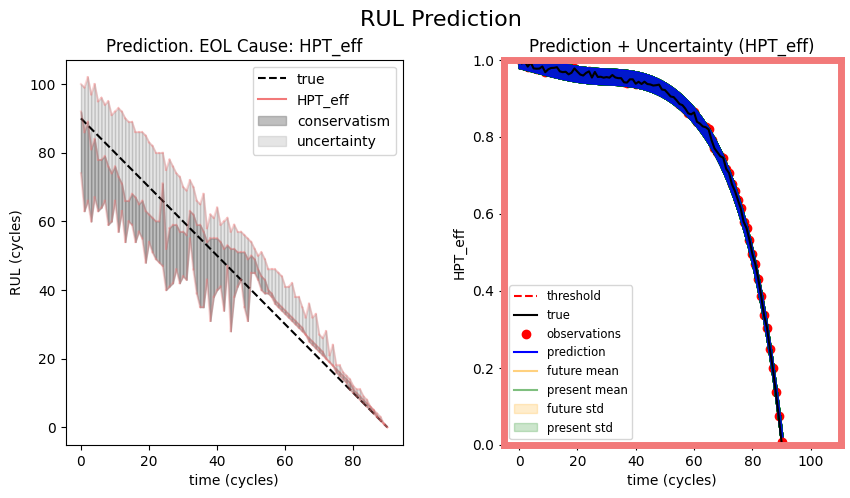

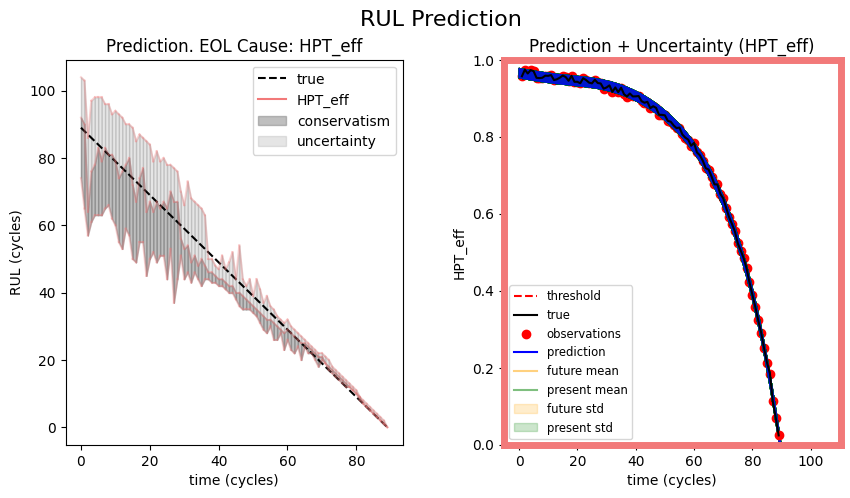

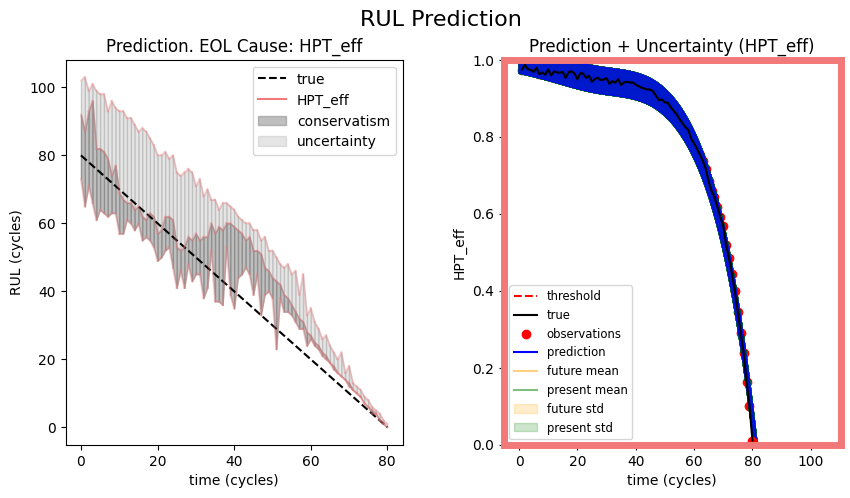

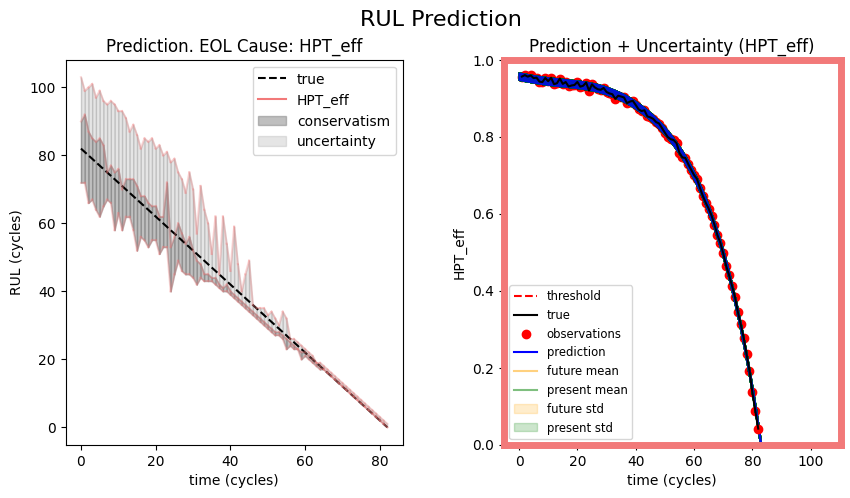

In [15]:
## Setup Method
y_lim=get_from(performs_info,'y_lim')
loc=get_from(performs_info,'loc')
monot=get_from(performs_info,'monot')
EOL_cause_text =get_from(performs_info,'EOL_cause') 

subgroup_distributions={name:group_dist.get_sub_watercan(range(n_train_unit)) for name,group_dist in group_distributions.items()}

## Results initialization
trues = []
pred_names='acc','csv','unc'
RMSEs={key: [] for key in pred_names}
predss={key: [] for key in pred_names}
causess={key: [] for key in pred_names}

# For inmidiate information
pred_acc=[]
true=[]


n_unit=1 if exp=='try' else n_test_unit
for unit in range(n_unit): 
        A={}
        S={}
        b={}
        threshold={}
        for name in performs_info.keys():
                A[name]= As[name][unit][:,:n_train_unit]
                S[name]= Ss[name][unit][:,:n_train_unit]
                b[name]= bs[name][unit]
                thres=np.interp(t, times_thresholds[unit], thresholds[name][unit])
                threshold[name]=torch.tensor(thres,dtype=torch.float32,device=device)

        preds,causes=make_rul_video(unit,t,t_observ[unit],rul[unit],EOLcause[unit],
                                monot, threshold, subgroup_distributions, A, b, S, gamma, y_lim, loc,
                                perform_names=performs_info.keys(),causes_text=EOL_cause_text,time_unit=time_unit,
                                n_train_unit=n_train_unit, n_paths=n_paths, lr=lr,forgetting=forgetting,max_life = max_life,
                                accel=accel//3600, save=exp_address,conserv=conserv_pred)
        y_true=rul[unit]

        for name in pred_names:
                RMSE=np.sqrt(np.mean((preds[name]-y_true)**2))
                print(f"RMSE_{name}: {RMSE}")
                RMSEs[name].append(RMSE)
                predss[name].append(preds[name])
                causess[name].append(causes[name])
        trues.append(y_true)


## Save predictions
torch.save(predss,f'{exp_address}'+'preds.pt')
torch.save(causess,f'{exp_address}'+'causes.pt')
torch.save(trues,f'{exp_address}'+'trues.pt')


## Accurate prediction Results
print('----------------------------------')
error=np.concatenate(predss['acc'])-np.concatenate(trues)
RMSE=np.sqrt(np.mean(error**2))
print(f"RMSE_{name} mean: {RMSE}")
print(f"RMSE_{name} std: {np.std(error)}")
print('----------------------------------')


#### Load for checking

In [16]:
predss=torch.load(f'{exp_address}/preds.pt')
trues=torch.load(f'{exp_address}/trues.pt')

In [17]:
for name in pred_names:
        print(f'------------------------------- {name} RMSE -------------------------------')
        for unit in range(len(trues)):
                RMSE=np.sqrt(np.mean((predss[name][unit]-trues[unit])**2))
                print(f"unit {unit}: {RMSE}")
        print('----------------------------------')
        error=np.concatenate(predss[name])-np.concatenate(trues)
        RMSE=np.sqrt(np.mean(error**2))
        print(f"RMSE_{name} mean: {RMSE}")
        print(f"RMSE_{name} std: {np.std(error)}")
        print('----------------------------------')

------------------------------- acc RMSE -------------------------------
unit 0: 5.301876093411662
unit 1: 4.163331998932265
unit 2: 9.690264937962286
unit 3: 3.2892669560912404
----------------------------------
RMSE_acc mean: 6.048595477164663
RMSE_acc std: 5.84719947076493
----------------------------------
------------------------------- csv RMSE -------------------------------
unit 0: 13.050619959169806
unit 1: 12.340988615179905
unit 2: 7.425348642934943
unit 3: 6.8942091991705405
----------------------------------
RMSE_csv mean: 10.441972160884918
RMSE_csv std: 8.457162401374221
----------------------------------
------------------------------- unc RMSE -------------------------------
unit 0: 10.946924903148137
unit 1: 8.881941729649485
unit 2: 19.545451935374242
unit 3: 13.412366169511637
----------------------------------
RMSE_unc mean: 13.60732965316322
RMSE_unc std: 8.045660495200675
----------------------------------


In [18]:
exp_address

'./Library/MTL_2024-09-20_N-CMAPSS_DS01/_Experiments/threshold0_2024-09-21_try1_gamma1_lr1_forgetting1_seed0/'